In [ ]:
!nvidia-smi

Sat Dec  5 21:16:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, sys, math, time, datetime, random, glob, json
import numpy as np
import torch
import torch.nn as nn
from collections import defaultdict
from PIL import Image
from torch.autograd import Variable
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import datasets, transforms

In [ ]:
BASE_PATH = '/content/drive/My Drive/CVTermProject/train/'
CLASS_PATH = BASE_PATH + 'config/coco.names'
DATA_CONFIG_PATH = BASE_PATH + 'config/coco.data'
MODEL_CONFIG_PATH = BASE_PATH + 'config/yolov3.cfg'
WEIGHTS_PATH = BASE_PATH + 'checkpoints/new/499.weights'

In [ ]:
img_size=416
conf_thres=0.8
nms_thres=0.2

In [ ]:
def read_classes(path):
  with open(path, "r") as file:
    return file.read().strip().split("\n")

In [ ]:
def read_data(path):
  with open(path, "r") as file:
    data = file.readlines()

  config = dict()
  for d in data:
    d = d.strip()
    if len(d) < 1:
      continue
    key, value = d.split("=")
    key = key.strip()
    value = value.strip()
    config[key] = value
  
  return config

In [ ]:
def parse_model_config(path):
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

### Define YOLO model config

In [ ]:
class EmptyLayer(nn.Module):

  def __init__(self):
    super(EmptyLayer, self).__init__()

In [ ]:
class YOLO(nn.Module):
  def __init__(self, anchors, num_classes, dimensions):
    super(YOLO, self).__init__()
    self.anchors = anchors
    self.num_anchors = len(anchors)
    self.num_classes = num_classes
    self.bbox = 5 + num_classes
    self.dimensions = dimensions
    self.ignore_thres = 0.5
    self.lambda_coord = 1

    self.mse_loss = nn.MSELoss()
    self.bce_loss = nn.BCELoss()
    self.ce_loss = nn.CrossEntropyLoss()
  

  def forward(self, x, targets=None):
    nB = x.size(0)
    grid_size = x.size(2)

    stride = self.dimensions / grid_size

    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

    prediction = x.view(nB, self.num_anchors, self.bbox, grid_size, grid_size).permute(0, 1, 3, 4, 2).contiguous()

    # Get outputs
    x = torch.sigmoid(prediction[..., 0])  # Center x
    y = torch.sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    confidence = torch.sigmoid(prediction[..., 4])  # Conf
    clas = torch.sigmoid(prediction[..., 5:])  # Cls pred.
    scaled_anchors = FloatTensor([(i / stride, j / stride) for i, j in self.anchors])

    predicted_boxes = FloatTensor(prediction[..., :4].shape)
    predicted_boxes[..., 0] = x.data + torch.arange(grid_size).repeat(grid_size, 1).view([1, 1, grid_size, grid_size]).type(FloatTensor)
    predicted_boxes[..., 1] = y.data + torch.arange(grid_size).repeat(grid_size, 1).t().view([1, 1, grid_size, grid_size]).type(FloatTensor)
    predicted_boxes[..., 2] = torch.exp(w.data) * scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
    predicted_boxes[..., 3] = torch.exp(h.data) * scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    if targets is not None:
      if x.is_cuda:
        self.mse_loss = self.mse_loss.cuda()
        self.bce_loss = self.bce_loss.cuda()
        self.ce_loss = self.ce_loss.cuda()

      nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
          pred_boxes = predicted_boxes.cpu().data,
          pred_conf = confidence.cpu().data,
          pred_cls = clas.cpu().data,
          target=targets.cpu().data,
          anchors=scaled_anchors.cpu().data,
          num_anchors = self.num_anchors,
          num_classes = self.num_classes,
          grid_size=grid_size,
          ignore_thres=self.ignore_thres,
          img_dim = self.dimensions
      )

      proposals = int((confidence > 0.5).sum().item())
      recall = float(nCorrect / nGT) if nGT else 1

      precision = 0

      if proposals > 0:
        precision = float(nCorrect / proposals)

      mask = Variable(mask.type(ByteTensor))
      conf_mask = Variable(conf_mask.type(ByteTensor))

      tx = Variable(tx.type(FloatTensor), requires_grad=False)
      ty = Variable(ty.type(FloatTensor), requires_grad=False)
      tw = Variable(tw.type(FloatTensor), requires_grad=False)
      th = Variable(th.type(FloatTensor), requires_grad=False)
      tconf = Variable(tconf.type(FloatTensor), requires_grad=False)
      tcls = Variable(tcls.type(FloatTensor), requires_grad=False)

      conf_mask_true = mask
      conf_mask_false = conf_mask - mask

      loss_x = self.mse_loss(x[mask], tx[mask])
      loss_y = self.mse_loss(y[mask], ty[mask])
      loss_w = self.mse_loss(w[mask], tw[mask])
      loss_h = self.mse_loss(h[mask], th[mask])


      loss_conf = self.bce_loss(confidence[conf_mask_false], tconf[conf_mask_false]) + self.bce_loss(
                confidence[conf_mask_true], tconf[conf_mask_true])
      
      loss_cls = (1 / nB) * self.ce_loss(clas[mask], torch.argmax(tcls[mask], 1))
      loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

      return (loss, loss_x.item(), loss_y.item(), loss_w.item(), loss_h.item(), loss_conf.item(), loss_cls.item(), recall, precision)
    else:
      output = torch.cat((predicted_boxes.view(nB, -1, 4) * stride,
                         confidence.view(nB, -1, 1),
                         clas.view(nB, -1, self.num_classes)),
                         -1)
      
      return output


In [ ]:
class Darknet(nn.Module):

  def __init__(self, config_path, img_size=416):
    super(Darknet, self).__init__()
    self.modules = parse_model_config(config_path)
    self.hyperparameters, self.pipeline = create_pipeline(self.modules)
    self.img_size = img_size
    self.seen = 0
    self.header_info = np.array([0, 0, self.seen, 0])
    self.loss_names = ["x", "y", "w", "h", "conf", "cls", "recall", "precision"]


  def forward(self, x, targets=None):
    is_training = targets is not None

    output = []
    self.losses = defaultdict(float)
    layer_output = []

    for i , (module_def, module) in enumerate(zip(self.modules, self.pipeline)):
      if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
          x = module(x)
      elif module_def["type"] == "route":
          layer_i = [int(x) for x in module_def["layers"].split(",")]
          x = torch.cat([layer_output[i] for i in layer_i], 1)
      elif module_def["type"] == "shortcut":
          layer_i = int(module_def["from"])
          x = layer_output[-1] + layer_output[layer_i]
      elif module_def["type"] == "yolo":
          # Train phase: get loss
          if is_training:
              x, *losses = module[0](x, targets)
              for name, loss in zip(self.loss_names, losses):
                  self.losses[name] += loss
          # Test phase: Get detections
          else:
              x = module(x)
          output.append(x)
      layer_output.append(x)


    self.losses["recall"] /= 3
    self.losses["precision"] /= 3
    return sum(output) if is_training else torch.cat(output, 1)

  def load_weights(self, weights_path):
    # Open the weights file
    fp = open(weights_path, "rb")
    header = np.fromfile(fp, dtype=np.int32, count=5)  # First five are header values

    # Needed to write header when saving weights
    self.header_info = header

    self.seen = header[3]
    weights = np.fromfile(fp, dtype=np.float32)  # The rest are weights
    fp.close()

    ptr = 0
    for i, (module_def, module) in enumerate(zip(self.modules, self.pipeline)):
      if module_def["type"] == "convolutional":
        conv_layer = module[0]
        if module_def["batch_normalize"]:
            # Load BN bias, weights, running mean and running variance
            bn_layer = module[1]
            num_b = bn_layer.bias.numel()  # Number of biases
            # Bias
            bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
            bn_layer.bias.data.copy_(bn_b)
            ptr += num_b
            # Weight
            bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
            bn_layer.weight.data.copy_(bn_w)
            ptr += num_b
            # Running Mean
            bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
            bn_layer.running_mean.data.copy_(bn_rm)
            ptr += num_b
            # Running Var
            bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
            bn_layer.running_var.data.copy_(bn_rv)
            ptr += num_b
        else:
            # Load conv. bias
            num_b = conv_layer.bias.numel()
            conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
            conv_layer.bias.data.copy_(conv_b)
            ptr += num_b
          # Load conv. weights
        num_w = conv_layer.weight.numel()
        conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
        conv_layer.weight.data.copy_(conv_w)
        ptr += num_w


  def save_weights(self, path, cutoff=-1):

    fp = open(path, "wb")
    self.header_info[3] = self.seen
    self.header_info.tofile(fp)

    # Iterate through layers
    for i, (module_def, module) in enumerate(zip(self.modules[:cutoff], self.pipeline[:cutoff])):
        if module_def["type"] == "convolutional":
            conv_layer = module[0]
            # If batch norm, load bn first
            if module_def["batch_normalize"]:
                bn_layer = module[1]
                bn_layer.bias.data.cpu().numpy().tofile(fp)
                bn_layer.weight.data.cpu().numpy().tofile(fp)
                bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                bn_layer.running_var.data.cpu().numpy().tofile(fp)
            # Load conv bias
            else:
                conv_layer.bias.data.cpu().numpy().tofile(fp)
            # Load conv weights
            conv_layer.weight.data.cpu().numpy().tofile(fp)

    fp.close()


In [ ]:
def create_pipeline(modules):
  hyperparameters = modules.pop(0)
  output_filters = [int(hyperparameters['channels'])]
  pipeline = nn.ModuleList()

  for i, module in enumerate(modules):
    mod = nn.Sequential()
    module_type = module['type']

    if module_type == 'convolutional':
      batch_norm = int(module['batch_normalize'])
      filters = int(module['filters'])

      kernel_size = int(module['size'])

      padding = (kernel_size - 1) // 2 if int(module['pad']) else 0

      mod.add_module("conv_%d" % i, nn.Conv2d(in_channels = output_filters[-1],
                                              out_channels = filters,
                                              kernel_size = kernel_size,
                                              stride = int(module['stride']),
                                              padding = padding,
                                              bias = not batch_norm))
      
      if batch_norm:
        mod.add_module('batch_norm_%d' % i, nn.BatchNorm2d(filters))

      if module['activation'] == 'leaky':
        mod.add_module('leaky_%d' % i, nn.LeakyReLU(0.1))

    elif module_type == 'upsample':
      stride = int(module['stride'])
      mod.add_module('upsample_%d' % i, nn.Upsample(scale_factor=stride, 
                                                    mode='nearest'))
      
    elif module_type == 'maxpool':
      kernel_size = int(module['size'])
      stride = int(module['stride'])

      if kernel_size == 2 and stride == 1:
        padding = nn.ZeroPad2d((0, 1, 0, 1))
        mod.add_module("_debug_padding_%d" % i, padding)

      mod.add_module("Maxpool_%d" % i, nn.MaxPool2d(kernel_size=kernel_size,
                                                    stride = stride,
                                                    padding=int((kernel_size - 1) // 2)))

    elif module_type == 'route':
      layers = [int(x) for x in module["layers"].split(",")]
      filters = sum([output_filters[layer_i] for layer_i in layers])
      mod.add_module('route_%d' % i, EmptyLayer())

    elif module_type == 'shortcut':
      filters = output_filters[int(module['from'])]
      mod.add_module("shortcut_%d" % i, EmptyLayer())

    elif module_type == 'yolo':
      anchor_idx = [int(x) for x in module['mask'].split(',')]
      anchors = [int(x) for x in module['anchors'].split(',')]

      anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
      anchors = [anchors[i] for i in anchor_idx]

      num_classes = int(module['classes'])
      img_height = int(hyperparameters['height'])

      mod.add_module('yolo_%d' % i, YOLO(anchors, num_classes, img_height))
    pipeline.append(mod)
    output_filters.append(filters)

  return hyperparameters, pipeline

In [ ]:
# Load model and weights
def get_model(weight_path):
  model = Darknet(MODEL_CONFIG_PATH, img_size=img_size)
  model.load_weights(weight_path)

  if torch.cuda.is_available():
    model.cuda()

  model.eval()

  return model


In [ ]:
classes = read_classes(CLASS_PATH)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

### Object Detection

In [ ]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
  
    return iou

In [ ]:
def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    image_pred = prediction[0]
    conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
    
    image_pred = image_pred[conf_mask]

    if image_pred.size(0):
      class_conf, class_pred = torch.max(image_pred[:, 5 : 5 + num_classes], 1, keepdim=True)
      detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
      unique_labels = detections[:, -1].cpu().unique()
      if prediction.is_cuda:
          unique_labels = unique_labels.cuda()
      for c in unique_labels:
          detections_class = detections[detections[:, -1] == c]
          _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
          detections_class = detections_class[conf_sort_index]
          max_detections = []
          while detections_class.size(0):
              max_detections.append(detections_class[0].unsqueeze(0))

              if len(detections_class) == 1:
                  break
              
              ious = bbox_iou(max_detections[-1], detections_class[1:])
              detections_class = detections_class[1:][ious < nms_thres]

          max_detections = torch.cat(max_detections).data
          output[0] = (
              max_detections if output[0] is None else torch.cat((output[0], max_detections))
          )

    return output

In [ ]:
def detect_image(img, model):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, 3, conf_thres, nms_thres)
    return detections[0]

### Evaluate the object detection model

In [ ]:
with open(BASE_PATH + 'data/val.txt', 'r') as f:
  validation_files = f.readlines()

len(validation_files)

425

In [48]:
for epoch in range(-1, 520, 25):
  e = epoch + 1 if epoch == -1 else epoch

  print(e, epoch)

0 -1
24 24
49 49
74 74
99 99
124 124
149 149
174 174
199 199
224 224
249 249
274 274
299 299
324 324
349 349
374 374
399 399
424 424
449 449
474 474
499 499


In [49]:
epochs_map = {}
for epoch in range(-1, 520, 25):
  e = epoch + 1 if epoch == -1 else epoch

  wght_path = BASE_PATH + 'checkpoints/new/' + str(e) + '.weights'
  print(wght_path)
  model = get_model(weight_path=wght_path)
  
  ambulance = []
  building = []
  person = []

  for _, i in enumerate(validation_files):
    img_path2 = i.strip()
    # print(img_path2)
    prev_time = time.time()
    img = Image.open(img_path2)
    # print(img.size)
    try:
      detections = detect_image(img, model)

      inference_time = datetime.timedelta(seconds=time.time() - prev_time)
      # print ('Inference Time: %s' % (inference_time))

      # Get bounding-box colors
      cmap = plt.get_cmap('tab20b')
      colors = [cmap(i) for i in np.linspace(0, 1, 20)]

      img = np.array(img)
      # plt.figure()
      # fig, ax = plt.subplots(1, figsize=(12,9))
      # ax.imshow(img)
      pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
      pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
      unpad_h = img_size - pad_y
      unpad_w = img_size - pad_x

      if detections is not None:
          unique_labels = detections[:, -1].cpu().unique()
          n_cls_preds = len(unique_labels)
          bbox_colors = random.sample(colors, n_cls_preds)

          # browse detections and draw bounding boxes
          for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
              box_h = ((y2 - y1) / unpad_h) * img.shape[0]
              box_w = ((x2 - x1) / unpad_w) * img.shape[1]
              y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
              x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
              # color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
              # bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
              predicted_class = classes[int(cls_pred)]
              # ax.add_patch(bbox)
              # plt.text(x1, y1, s=predicted_class, color='white', verticalalignment='top',
                      # bbox={'color': color, 'pad': 0})
    
              temp = dict()
              temp["confidence"] = str(cls_conf.cpu().numpy())
              temp['file_id'] = img_path2[img_path2.rfind('/') + 1:]
              temp['bbox'] = str(x1.cpu().numpy()) + " " + str(y1.cpu().numpy()) + " " + str(box_w.cpu().numpy()) + " " + str(box_h.cpu().numpy())

              if predicted_class == 'ambulance':
                ambulance.append(temp)
              elif predicted_class == 'building':
                building.append(temp)
              else:
                person.append(temp)
              # print('~~~~   ',predicted_class, y1.cpu().numpy(), x1.cpu().numpy(), box_h.cpu().numpy(), box_w.cpu().numpy(), img_path2[img_path2.rfind('/') + 1:])
      # plt.axis('off')
      # plt.savefig(img_path2.replace('dataset', 'dataset-output'), bbox_inches='tight', pad_inches=0.0)
    except Exception as excep:
      print("e.message = ", excep)

  print("Completed Epoch:", str(epoch))
  epochs_map[e] = {'ambulance': ambulance, 'building': building, 'person': person}


/content/drive/My Drive/CVTermProject/train/checkpoints/new/0.weights
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 4)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.message =  The number of elements in 'fill' does not match the number of bands of the image (3 != 1)
e.m

In [50]:
  epochs_map[499]

{'ambulance': [{'bbox': '18.170223 235.61057 957.0023 580.68524',
   'confidence': '0.28961357',
   'file_id': '03245963d6ca3178.jpg'},
  {'bbox': '140.86726 141.34521 744.21533 330.0669',
   'confidence': '0.9999813',
   'file_id': '6a07853df361c94c.jpg'},
  {'bbox': '165.56866 66.946815 681.13605 503.23328',
   'confidence': '0.9999995',
   'file_id': 'c7bf2b9451a26279.jpg'},
  {'bbox': '167.1542 327.91232 368.7045 220.9328',
   'confidence': '0.9999993',
   'file_id': '26fd9d582e3d6a29.jpg'},
  {'bbox': '192.13158 12.417162 789.8934 492.70563',
   'confidence': '0.99999535',
   'file_id': '1abc74ac4318dbc1.jpg'},
  {'bbox': '72.003235 54.641735 872.39594 620.44556',
   'confidence': '0.99979883',
   'file_id': '9ea4706b69ca4217.jpg'},
  {'bbox': '62.25665 42.81994 910.456 525.45337',
   'confidence': '0.9999628',
   'file_id': '1dbc8d811c800ef7.jpg'},
  {'bbox': '202.82704 138.50783 620.37146 378.58865',
   'confidence': '0.99997675',
   'file_id': '5e61a07f1d23ec8d.jpg'},
  {'bbox'

### Calculate mAP (Mean Average Precision) 

In [51]:
GT_PATH = BASE_PATH + 'data/dataset/labels'
TEMP_FILES_PATH = BASE_PATH + 'dataset/tempFiles'
os.makedirs(TEMP_FILES_PATH, exist_ok=True)

In [52]:
MIN_OVERLAP = 0.5

In [53]:
def log_average_miss_rate(prec, rec, num_images):
    if prec.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = (1 - prec)
    mr = (1 - rec)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

In [54]:
def voc_ap(rec, prec):
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre

In [55]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

In [56]:
ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
if len(ground_truth_files_list) == 0:
    error("Error: No ground-truth files found!")

ground_truth_files_list.sort()


In [57]:
def get_ground_truth_files():
  gt_files = []

  gt_counter_per_class = defaultdict(int)
  counter_images_per_class = defaultdict(int)

  for txt_file in validation_files:
        if len(txt_file) < 1:
          continue
        txt_file = txt_file.strip()
        img_shape = np.array(Image.open(txt_file)).shape
        h = img_shape[0]
        w = img_shape[1]
        txt_file = txt_file.replace('.jpg', '.txt').replace('images', 'labels')
        file_id = txt_file.split(".txt", 1)[0]
        file_id = os.path.basename(os.path.normpath(file_id))
        
        lines_list = file_lines_to_list(txt_file)
        
        bounding_boxes = []
        
        already_seen_classes = []
        for line in lines_list:
          class_name, left, top, right, bottom = line.split()
          bbox = left + ' ' + top + ' ' + right + ' ' + bottom

          if class_name == '0':
            class_name = 'ambulance'
          elif class_name == '1':
            class_name = 'building'
          else:
            class_name = 'person'
          
          bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
          gt_counter_per_class[class_name] += 1

          if class_name not in already_seen_classes:
              counter_images_per_class[class_name] += 1
              already_seen_classes.append(class_name)

        # dump bounding_boxes into a ".json" file
        new_temp_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
        gt_files.append(new_temp_file)
        with open(new_temp_file, 'w') as outfile:
            json.dump(bounding_boxes, outfile)
  return gt_counter_per_class, counter_images_per_class   

In [58]:
def scale_bbox(img_path, x_min, y_min, width, height):
  img = Image.open(img_path)
  img = np.array(img)
  scale_up = img.shape

  x_min = x_min * scale_up[1]
  y_min = y_min * scale_up[0]

  width = width * scale_up[1]
  height = height * scale_up[0]

  w = width / 2
  h = height / 2

  x1 = int(x_min - w)
  y1 = int(y_min - h)

  gt_box = torch.FloatTensor(np.array([x1, y1, width, height])).unsqueeze(0)

  return gt_box

In [59]:
for epoch in epochs_map.keys():
  print(epochs_map[epoch])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [60]:
for epoch in epochs_map.keys():
  sum_AP = 0.0
  ap_dictionary = {}
  lamr_dictionary = {}
  count_true_positives = {}
  predicted_bbox = epochs_map[epoch]
  n_classes = len(predicted_bbox)

  gt_counter_per_class, counter_images_per_class = get_ground_truth_files()
  for class_name in predicted_bbox.keys():
      count_true_positives[class_name] = 0
      dr_data = predicted_bbox[class_name]
      nd = len(dr_data)
      tp = [0] * nd 
      fp = [0] * nd
      idxx = 0
      for idx, detection in enumerate(dr_data):

          im_path = BASE_PATH + 'data/dataset/images/' + detection["file_id"]

          file_id = detection["file_id"].replace('.jpg', '')
          gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
          ground_truth_data = json.load(open(gt_file))
          ovmax = -1
          gt_match = -1

          bb = [ float(x) for x in detection["bbox"].split() ]
          for obj in ground_truth_data:
              
              if obj["class_name"] == class_name:
                  gt = obj["bbox"].split()
                  gtx1 = float(gt[0])
                  gty1 = float(gt[1])
                  gtx2 = float(gt[2])
                  gty2 = float(gt[3])
                  gt_box = scale_bbox(im_path, gtx1, gty1, gtx2, gty2)
                  pred_box = torch.FloatTensor(np.array([bb[0], bb[1], bb[2], bb[3]])).unsqueeze(0)
                  ov = bbox_iou(gt_box, pred_box, x1y1x2y2=False)

                  # print('\t gt_box:', gt_box)
                  # print('\t pred_box:', pred_box)
                  # print('\t\t iou:', ov)
                  if ov > ovmax:
                      ovmax = ov
                      gt_match = obj
          
          if ovmax >= MIN_OVERLAP:
              if not bool(gt_match["used"]):
                  tp[idx] = 1
                  gt_match["used"] = True
                  count_true_positives[class_name] += 1
                  with open(gt_file, 'w') as f:
                          f.write(json.dumps(ground_truth_data))
              else:
                  fp[idx] = 1
          else:
              fp[idx] = 1
              
      cumsum = 0
      for idx, val in enumerate(fp):
          fp[idx] += cumsum
          cumsum += val
      cumsum = 0
      for idx, val in enumerate(tp):
          tp[idx] += cumsum
          cumsum += val
      rec = tp[:]
      for idx, val in enumerate(tp):
          rec[idx] = float(tp[idx]) / gt_counter_per_class[class_name]
      prec = tp[:]
      for idx, val in enumerate(tp):
          prec[idx] = float(tp[idx]) / (fp[idx] + tp[idx])

      ap, mrec, mprec = voc_ap(rec[:], prec[:])
      sum_AP += ap
    
      rounded_prec = [ '%.2f' % elem for elem in prec ]
      rounded_rec = [ '%.2f' % elem for elem in rec ]
    
      ap_dictionary[class_name] = ap

      n_images = counter_images_per_class[class_name]
      lamr, mr, fppi = log_average_miss_rate(np.array(prec), np.array(rec), n_images)
      lamr_dictionary[class_name] = lamr

  mAP = sum_AP / n_classes
  epochs_map[epoch]['mAP'] = mAP * 100

  print("mAP for %d epoch = %.2f " % (epoch, float(mAP*100)))
  del gt_counter_per_class
  del counter_images_per_class


mAP for 0 epoch = 0.21 
mAP for 24 epoch = 11.90 
mAP for 49 epoch = 31.49 
mAP for 74 epoch = 13.50 
mAP for 99 epoch = 36.99 
mAP for 124 epoch = 40.90 
mAP for 149 epoch = 40.69 
mAP for 174 epoch = 43.08 
mAP for 199 epoch = 14.16 
mAP for 224 epoch = 33.82 
mAP for 249 epoch = 45.24 
mAP for 274 epoch = 44.76 
mAP for 299 epoch = 45.77 
mAP for 324 epoch = 22.70 
mAP for 349 epoch = 42.21 
mAP for 374 epoch = 49.32 
mAP for 399 epoch = 46.42 
mAP for 424 epoch = 45.12 
mAP for 449 epoch = 49.68 
mAP for 474 epoch = 49.20 
mAP for 499 epoch = 51.86 


In [61]:
epochs_map[0]['mAP']

0.21466340940523068

In [62]:
list_epochs = list(epochs_map.keys())
list_map = list()
for e in epochs_map.keys():
  print(e)
  list_map.append(epochs_map[e]['mAP'])

0
24
49
74
99
124
149
174
199
224
249
274
299
324
349
374
399
424
449
474
499


In [66]:
import pandas as pd

df = pd.DataFrame({'epoch': list_epochs, 'mAP': list_map})

# for x, y in zip(list_epochs, list_map):
#   print(x, y)
df

,epoch,mAP
0,0,0.214663
1,24,11.903529
2,49,31.489895
3,74,13.495107
4,99,36.987831
5,124,40.898036
6,149,40.692278
7,174,43.084253
8,199,14.162727
9,224,33.815586


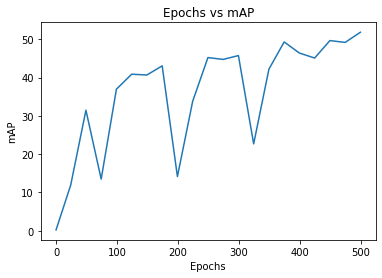

In [64]:
plt.plot(list_epochs, list_map)
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.title('Epochs vs mAP')
plt.show()